In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


In [144]:

# Load the dataset
file_path = './DataCollected.csv'
data = pd.read_csv(file_path)


In [145]:

# 1. Convert Dates and Sort Data
data['Date'] = pd.to_datetime(data['Date'], format='%y%m%d')
data = data.sort_values(by='Date')


In [146]:

# 2. Generate Log Returns for Price Columns
price_columns = ['NVDA', 'AAPL', 'AMD', 'AVGO', 'INTC', 'QCOM', 'SP500', 'NASDAQCOM', 'DJIA']
for col in price_columns:
    data[f'{col}_Log_Return'] = np.log(data[col] / data[col].shift(1))

# Drop the first row with NaN log returns
data = data.dropna(subset=[f'{col}_Log_Return' for col in price_columns])


In [147]:
# 3. Transform Indicators to Improve Stationarity
# First ensure positivity, then take the log, and finally difference the series.

indicator_columns = ['SMA', 'EMA', 'MACD', 'MACD_Signal', 'RSI', 'OBV']

for col in indicator_columns:
    # Check min value to ensure positivity before log
    min_val = data[col].min()
    if min_val <= 0:
        shift_val = 1 - min_val
        data[col] = data[col] + shift_val
    
    # Take the log of the (shifted) values
    data[col] = np.log(data[col])
    
    # Apply first differencing to achieve stationarity
    # This will introduce a NaN in the first row for each column.
    data[col] = data[col].diff()

# Drop rows with NaN introduced by differencing
data = data.dropna(subset=indicator_columns)


In [148]:

# 4. Perform Stationarity Tests on Log Returns
print("\nStationarity Test Results for Log Returns (Augmented Dickey-Fuller Test):")
for col in [f'{col}_Log_Return' for col in price_columns]:
    result = adfuller(data[col])
    print(f'{col}: ADF Statistic = {result[0]}, p-value = {result[1]}')
    if result[1] >= 0.05:
        print(f"Warning: {col} might not be stationary. Consider differencing or further transformation.")



Stationarity Test Results for Log Returns (Augmented Dickey-Fuller Test):
NVDA_Log_Return: ADF Statistic = -4.200746149666034, p-value = 0.0006569865701633264
AAPL_Log_Return: ADF Statistic = -14.643984060413343, p-value = 3.5867942605599006e-27
AMD_Log_Return: ADF Statistic = -16.261640879235742, p-value = 3.5608330755696156e-29
AVGO_Log_Return: ADF Statistic = -5.3961866751447545, p-value = 3.4502337451226206e-06
INTC_Log_Return: ADF Statistic = -7.574539370524751, p-value = 2.7840696593031397e-11
QCOM_Log_Return: ADF Statistic = -17.344115187018136, p-value = 5.318462375314627e-30
SP500_Log_Return: ADF Statistic = -14.89779849919029, p-value = 1.523010431815754e-27
NASDAQCOM_Log_Return: ADF Statistic = -15.38144048482431, p-value = 3.4033535862210936e-28
DJIA_Log_Return: ADF Statistic = -13.929390544375279, p-value = 5.122444892808757e-26


In [149]:
# 5. Perform Stationarity Tests on Transformed (Log + Differenced) Indicators
print("\nStationarity Test Results for Transformed Indicators (Augmented Dickey-Fuller Test):")
for col in indicator_columns:
    series = data[col].dropna()  # Ensure no NaNs
    result = adfuller(series)
    print(f'{col}: ADF Statistic = {result[0]}, p-value = {result[1]}')
    if result[1] >= 0.05:
        print(f"Warning: {col} might still not be stationary. Consider further transformation.")



Stationarity Test Results for Transformed Indicators (Augmented Dickey-Fuller Test):
SMA: ADF Statistic = -2.8334442020608126, p-value = 0.05365302086671547
EMA: ADF Statistic = -2.716803901194609, p-value = 0.07117532513325883
MACD: ADF Statistic = -3.5520208303188188, p-value = 0.006747383342239966
MACD_Signal: ADF Statistic = -3.825127655836131, p-value = 0.0026604393329288096
RSI: ADF Statistic = -16.437590696877898, p-value = 2.4450201554280454e-29
OBV: ADF Statistic = -7.1700972051029295, p-value = 2.819150746991044e-10


In [150]:

# 6. Z-Score Standardization for Log Returns
scaler_log_returns = StandardScaler()
log_return_columns = [f'{col}_Log_Return' for col in price_columns]
data[log_return_columns] = scaler_log_returns.fit_transform(data[log_return_columns])


In [151]:

# 7. Z-Score Standardization for Indicators
scaler_indicators = StandardScaler()
data[indicator_columns] = scaler_indicators.fit_transform(data[indicator_columns])


In [152]:

# 8. Check for Missing Values
print("\nMissing Values Check:")
print(data.isnull().sum())



Missing Values Check:
Unnamed: 0              0
Date                    0
NVDA                    0
SMA                     0
EMA                     0
AAPL                    0
AMD                     0
AVGO                    0
INTC                    0
QCOM                    0
ADS_Index               0
Mkt-RF                  0
SMB                     0
HML                     0
RMW                     0
CMA                     0
RF                      0
CBBTCUSD                0
CBETHUSD                0
SP500                   0
NASDAQCOM               0
DJIA                    0
MACD                    0
MACD_Signal             0
OBV                     0
RSI                     0
NVDA_Log_Return         0
AAPL_Log_Return         0
AMD_Log_Return          0
AVGO_Log_Return         0
INTC_Log_Return         0
QCOM_Log_Return         0
SP500_Log_Return        0
NASDAQCOM_Log_Return    0
DJIA_Log_Return         0
dtype: int64



Outlier Detection:


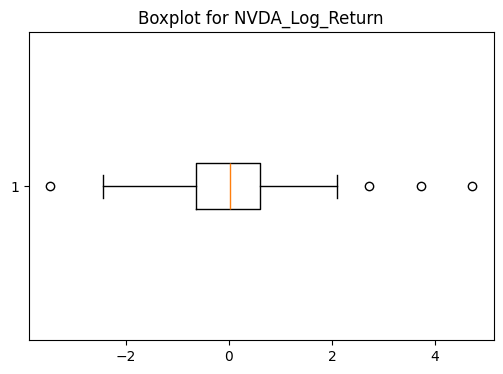

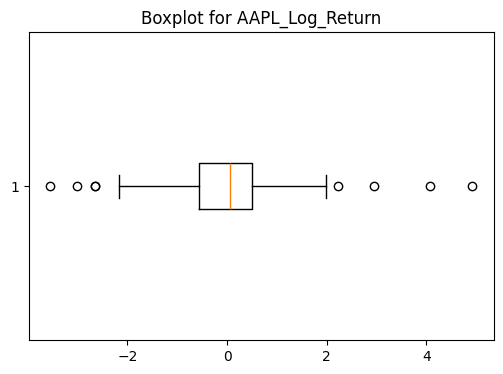

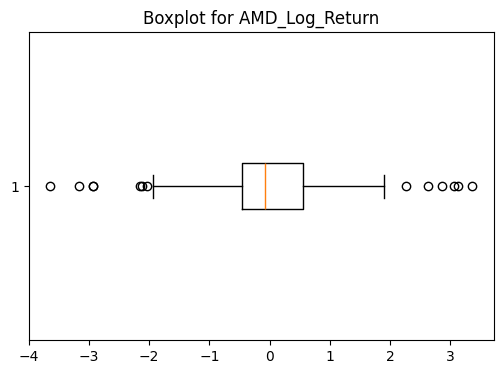

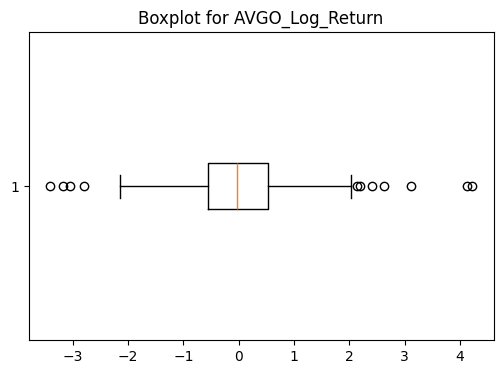

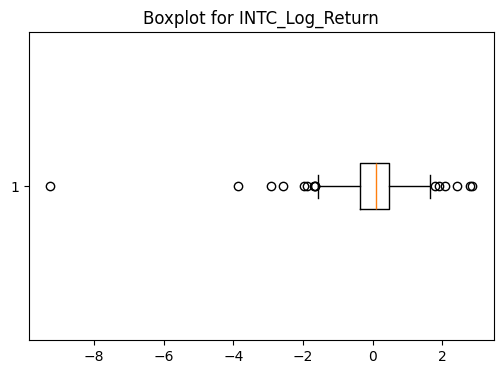

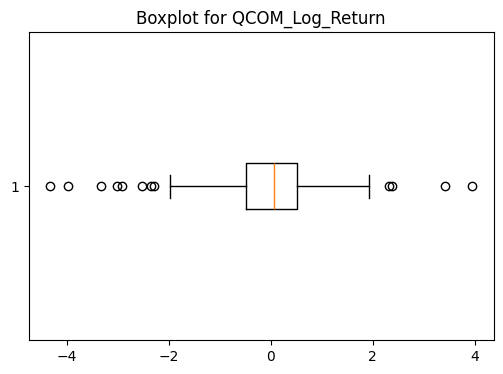

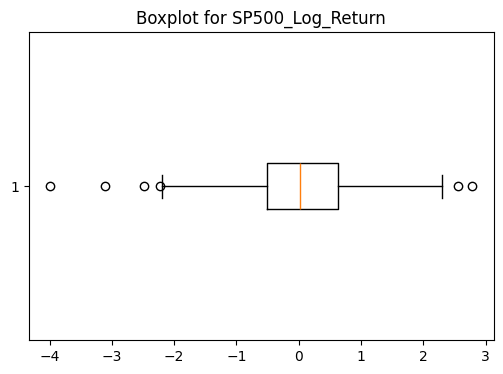

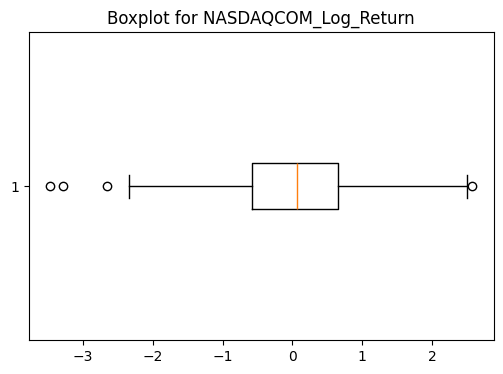

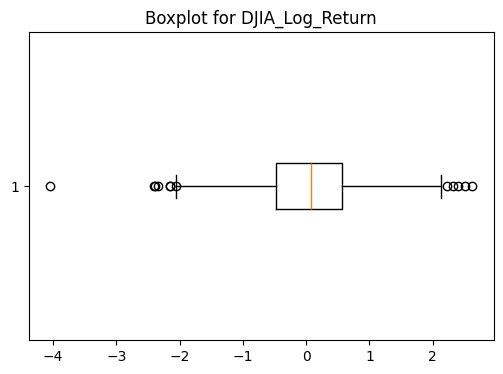

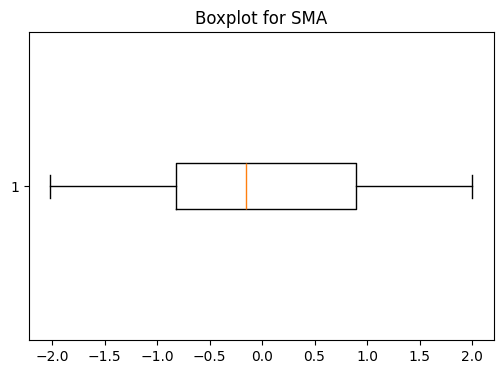

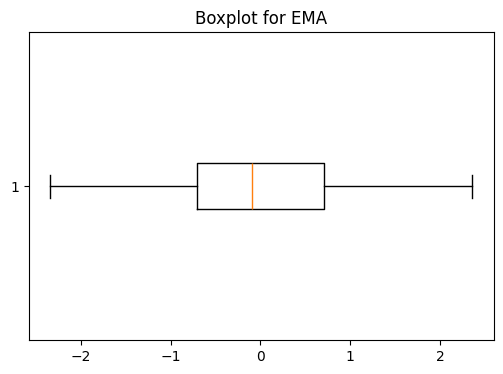

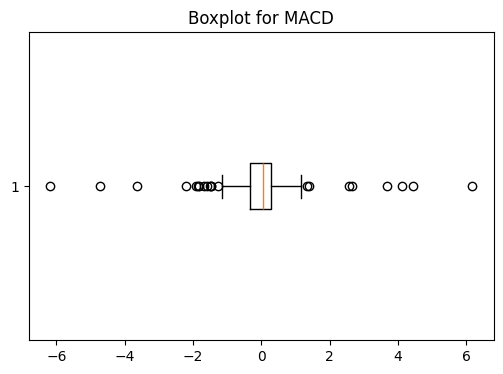

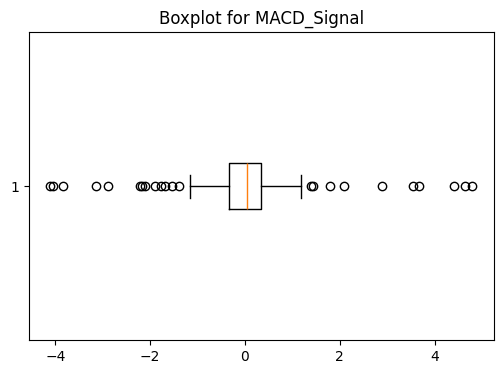

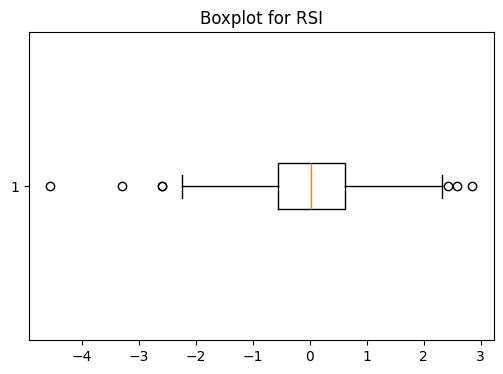

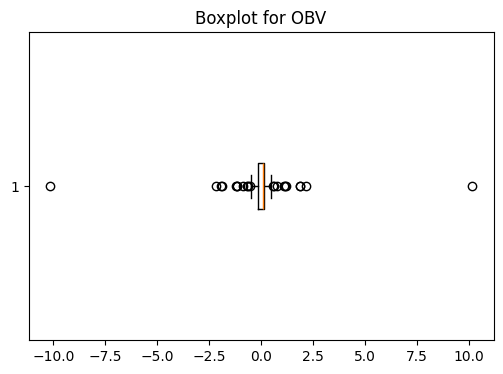

In [153]:

# 9. Detect and Handle Outliers (Visualize and Optionally Remove)
print("\nOutlier Detection:")
for column in log_return_columns + indicator_columns:
    plt.figure(figsize=(6, 4))
    plt.boxplot(data[column], vert=False)
    plt.title(f'Boxplot for {column}')
    plt.show()

# Optional: Remove outliers using the IQR method
for column in log_return_columns + indicator_columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


In [154]:

# 10. Check Correlation Matrix to Address Multicollinearity
print("\nCorrelation Matrix:")
correlation_matrix = data[log_return_columns + indicator_columns].corr()
print(correlation_matrix)

# (Optional) Drop highly correlated features if necessary
# Example: Drop SP500_Log_Return if it is highly correlated with NASDAQCOM_Log_Return or DJIA_Log_Return
# data = data.drop('SP500_Log_Return', axis=1)



Correlation Matrix:
                      NVDA_Log_Return  AAPL_Log_Return  AMD_Log_Return  \
NVDA_Log_Return              1.000000         0.028607        0.301176   
AAPL_Log_Return              0.028607         1.000000        0.069161   
AMD_Log_Return               0.301176         0.069161        1.000000   
AVGO_Log_Return              0.435255         0.233386        0.271454   
INTC_Log_Return              0.098696         0.165710        0.404682   
QCOM_Log_Return              0.348301         0.287092        0.406606   
SP500_Log_Return             0.438562         0.407508        0.437895   
NASDAQCOM_Log_Return         0.572143         0.478766        0.479104   
DJIA_Log_Return              0.068162         0.250026        0.235767   
SMA                          0.149502        -0.004159       -0.150096   
EMA                          0.230465        -0.071708       -0.146732   
MACD                         0.362138        -0.001999        0.098083   
MACD_Signal      

In [155]:

# 11. Prepare Final Dataset
final_columns = log_return_columns + indicator_columns
data = data.reset_index(drop=True)
final_data = data[final_columns]


# Save preprocessed data to a new file
output_file_path = './DataPreprocessed.csv'
final_data.to_csv(output_file_path)
print(f"\nPreprocessed data saved to {output_file_path}")



Preprocessed data saved to ./DataPreprocessed.csv
